In [1]:
from collections import defaultdict
from pymongo import MongoClient

client = MongoClient()
db = client["senators"]
coll = db["raw_xml"]

In [2]:
votes = defaultdict(dict)

for roll_call in coll.find({"congress": 113},{"raw":0}):
    for member in roll_call["votes"]:
        votes[member["name"]][(roll_call["session"],roll_call["vote_num"])] = member["vote_score"]

In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction import DictVectorizer

def graph_senators(names, senators):
    dict_vectorizer = DictVectorizer()
    features = dict_vectorizer.fit_transform(senators)

    labels = AgglomerativeClustering().fit_predict(features.toarray())

    matplotlib.rcParams['figure.figsize'] = (15.0,12.0)

    mds = MDS()
    coords = mds.fit_transform(features.toarray())
    plot = plt.scatter(coords[:,0], coords[:,1], c=labels, s=100)
    plt.axis("off")

    for i, (name, xy) in enumerate(zip(names, coords)):
        color = "red" if labels[i] else "blue"
        plt.annotate(name, xy = xy, xytext = (1, 1),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.3', fc=color,alpha = .4),
            arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0')
        )

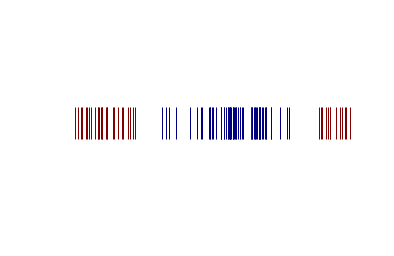

In [5]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np
import random

mds = MDS(n_components=1)
partisanship = mds.fit_transform(features.toarray())

%matplotlib inline
plt.scatter(partisanship, np.zeros_like(partisanship), c=labels,marker="|",s=1000)
# y=np.ones(np.shape(partisanship))
# plt.plot(partisanship,y,"|",ms=40,c=labels)
plt.axis("off")

# for name, val in zip(senator_names, partisanship)[0:2]:
#     plt.annotate(name, xy = (val, 0), xytext = (0, 1),
#         textcoords = 'offset points', ha = 'right', va = 'bottom')
plt.show()

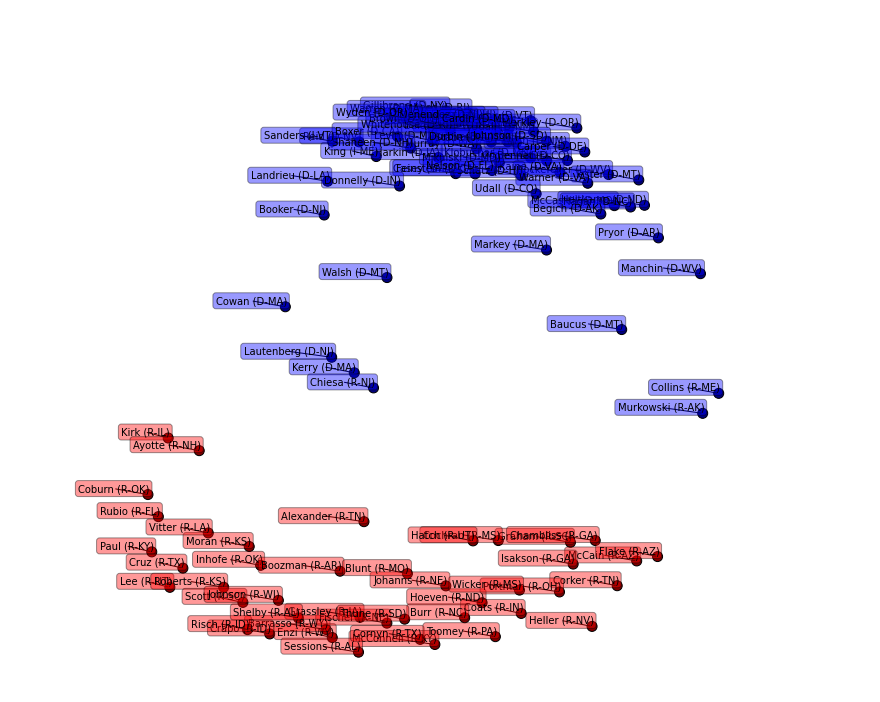

In [14]:
senator_names = votes.keys()
senators = [votes[name] for name in senator_names]
graph_senators(senator_names, senators)

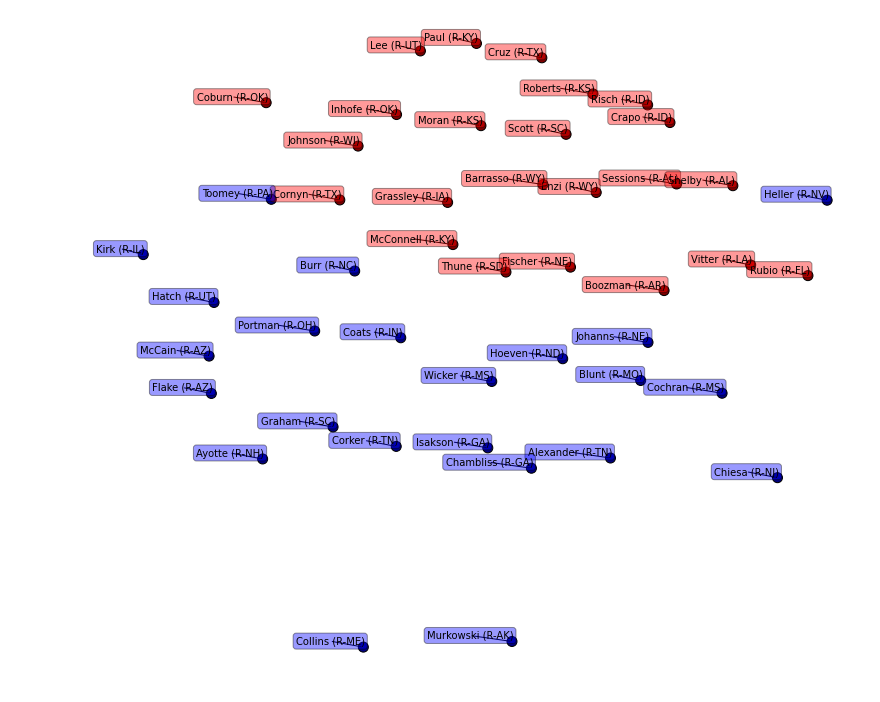

In [15]:
senator_names = filter(lambda name: "(R-" in name, votes.keys())
senators = [votes[name] for name in senator_names]

graph_senators(senator_names, senators)

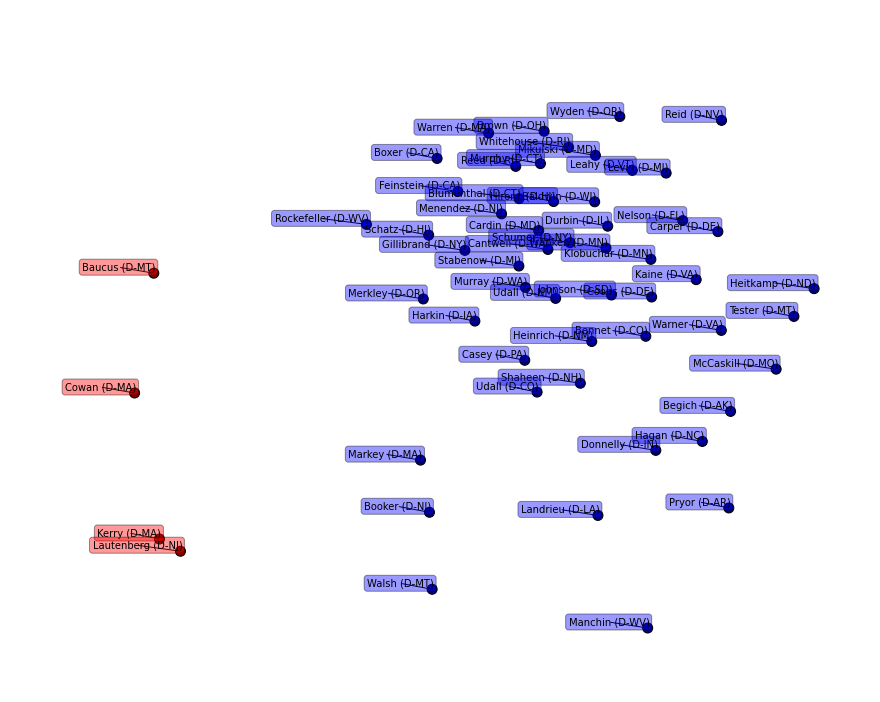

In [16]:
senator_names = filter(lambda name: "(D-" in name, votes.keys())
senators = [votes[name] for name in senator_names]


graph_senators(senator_names, senators)